In [1]:
pip install pyodbc pandas

   ---------------------------------------- 0.0/68.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/68.9 kB ? eta -:--:--
   ----------------- ---------------------- 30.7/68.9 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 68.9/68.9 kB 623.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\vsp27\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Establish connection using Windows Authentication
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=VSP_LENOVO;'  # Your server name from SSMS
    'DATABASE=master;'  # Change this after creating your database
    'Trusted_Connection=yes;'  # This enables Windows Authentication
)

# Test connection: List available databases
query = "SELECT name FROM sys.databases;"
df = pd.read_sql(query, conn)

# Show databases
print(df)

             name
0          master
1          tempdb
2           model
3            msdb
4  ecommerce_data
5     EcommerceDB


In [3]:
import pyodbc
import pandas as pd
import os

# SQL Server connection setup
server = 'VSP_LENOVO'
database = 'EcommerceDB'
conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;")
cursor = conn.cursor()

# Folder path where all your CSVs are saved
folder_path = r"C:\Users\vsp27\OneDrive\Desktop\Csv data\Ecommerce Data"

# CSV filenames mapped to SQL table names
csv_files = {
    "customers": "olist_customers_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "payments": "olist_order_payments_dataset.csv",
    "products": "olist_products_dataset.csv",
    "reviews": "olist_order_reviews_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "product_category_translation": "product_category_name_translation.csv"
}

# Define primary keys for deduplication (optional: skip if not needed)
primary_keys = {
    "customers": "customer_id",
    "sellers": "seller_id",
    "orders": "order_id",
    "order_items": "order_id",  # Composite key not handled here
    "payments": "order_id",
    "products": "product_id",
    "reviews": "review_id",
    "geolocation": "geolocation_zip_code_prefix",
    "product_category_translation": "product_category_name"
}

# Function to load CSVs into SQL
def load_csv_to_sql(table_name, csv_file, primary_key_column):
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)

    df = df.where(pd.notna(df), None)

# Drop duplicate rows based on primary key
    df.drop_duplicates(subset=primary_key_column, inplace=True)

    # Check for duplicate rows already in SQL
    try:
        existing_keys_query = f"SELECT {primary_key_column} FROM {table_name}"
        existing_keys_df = pd.read_sql(existing_keys_query, conn)

        if primary_key_column in df.columns:
            df = df[~df[primary_key_column].isin(existing_keys_df[primary_key_column])]
        else:
            print(f"⚠️ Column {primary_key_column} not found in CSV for {table_name}, skipping deduplication.")
    except Exception as e:
        print(f"⚠️ Couldn't fetch existing keys for {table_name}: {e}")

    if df.empty:
        print(f"✅ No new rows to insert for {table_name}")
        return

    # Prepare insert SQL
    columns = ", ".join(df.columns)
    placeholders = ", ".join(["?"] * len(df.columns))
    insert_sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"

    try:
        records = df.itertuples(index=False, name=None)
        cursor.executemany(insert_sql, list(records))
        conn.commit()
        print(f"✅ Inserted {len(df)} rows into {table_name}")
    except Exception as e:
        print(f"❌ Failed to insert into {table_name}: {e}")

# Run for all tables
for table, csv_file in csv_files.items():
    pk = primary_keys.get(table, None)
    load_csv_to_sql(table, csv_file, pk)


✅ No new rows to insert for customers
✅ No new rows to insert for sellers
✅ No new rows to insert for orders
✅ No new rows to insert for order_items
✅ No new rows to insert for payments
✅ No new rows to insert for products
✅ No new rows to insert for reviews
✅ No new rows to insert for geolocation
✅ No new rows to insert for product_category_translation


In [4]:
query = """
SELECT 'customers' AS TableName, COUNT(*) AS TotalRows FROM customers
UNION ALL
SELECT 'sellers', COUNT(*) FROM sellers
UNION ALL
SELECT 'orders', COUNT(*) FROM orders
UNION ALL
SELECT 'order_items', COUNT(*) FROM order_items
UNION ALL
SELECT 'payments', COUNT(*) FROM payments
UNION ALL
SELECT 'products', COUNT(*) FROM products
UNION ALL
SELECT 'reviews', COUNT(*) FROM reviews
UNION ALL
SELECT 'geolocation', COUNT(*) FROM geolocation
UNION ALL
SELECT 'product_category_translation', COUNT(*) FROM product_category_translation;
"""

df = pd.read_sql_query(query, conn)
print(df)


                      TableName  TotalRows
0                     customers      99441
1                   order_items     112650
2                       sellers       3095
3                        orders      99441
4                      payments     103886
5                      products      32340
6                       reviews      98410
7  product_category_translation         71
8                   geolocation    1000163


In [5]:
query = """
SELECT TOP 5 
       c.customer_state,
       c.customer_city, 
       COUNT(o.order_id) AS total_orders,
       SUM(oi.price) AS total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp BETWEEN CAST('2016-01-01' AS DATETIME2) 
                                     AND CAST('2018-12-31' AS DATETIME2)
GROUP BY c.customer_state, c.customer_city
ORDER BY total_revenue DESC;
"""

df = pd.read_sql_query(query, conn)

# Display the DataFrame with styling
df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#dbeafe'), ('font-weight', 'bold')]}]
).set_properties(**{
    'background-color': '#f9fafb',
    'border': '1px solid #ccc',
    'color': '#111827',
    'font-family': 'Segoe UI',
    'text-align': 'center'
}).set_caption("Top 5 Cities by Total Revenue (2016–2018)")

,customer_state,customer_city,total_orders,total_revenue
0,SP,sao paulo,17808,1914924.540000
1,RJ,rio de janeiro,7837,992538.860000
2,MG,belo horizonte,3144,355611.130000
3,DF,brasilia,2392,301920.250000
4,PR,curitiba,1751,211738.060000


In [6]:
query = """
WITH customer_activity AS (
    SELECT 
        customer_id, 
        DATEFROMPARTS(YEAR(order_purchase_timestamp), MONTH(order_purchase_timestamp), 1) AS month
    FROM orders
    GROUP BY customer_id, DATEFROMPARTS(YEAR(order_purchase_timestamp), MONTH(order_purchase_timestamp), 1)
),
monthly_churn AS (
    SELECT 
        month,
        COUNT(DISTINCT customer_id) AS active_customers,
        LAG(COUNT(DISTINCT customer_id)) OVER (ORDER BY month) AS previous_month_customers
    FROM customer_activity
    GROUP BY month
)
SELECT 
    month, 
    active_customers,
    previous_month_customers,
    (previous_month_customers - active_customers) * 100.0 / NULLIF(previous_month_customers, 0) AS churn_rate
FROM monthly_churn
WHERE previous_month_customers IS NOT NULL;
"""

df = pd.read_sql_query(query, conn)

# Display the DataFrame with styling
df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#dbeafe'), ('font-weight', 'bold')]}]
).set_properties(**{
    'background-color': '#f9fafb',
    'border': '1px solid #ccc',
    'color': '#111827',
    'font-family': 'Segoe UI',
    'text-align': 'center'
}).set_caption("Churn rate")

,month,active_customers,previous_month_customers,churn_rate
0,2017-05-01,3700,2404,-53.910150
1,2017-12-01,5673,7544,24.801166
2,2018-07-01,6292,6167,-2.026917
3,2017-01-01,800,1,-79900.000000
4,2017-08-01,4331,4026,-7.575758
5,2018-03-01,7211,6728,-7.178954
6,2018-10-01,4,16,75.000000
7,2016-12-01,1,324,99.691358
8,2017-07-01,4026,3245,-24.067797
9,2018-02-01,6728,7269,7.442564


In [7]:
query = """
SELECT 
    revenue.year,
    revenue.month_name,
    revenue.total_revenue,
    reviews.average_review_score,
    COALESCE(payments.total_payment, 0) AS total_payment,
    payments.payment_type

FROM 
    (SELECT 
        MONTH(oi.shipping_limit_date) AS month,
        YEAR(oi.shipping_limit_date) AS year,
        DATENAME(MONTH, oi.shipping_limit_date) AS month_name,  
        SUM(oi.price) AS total_revenue
    FROM order_items oi
    WHERE oi.shipping_limit_date BETWEEN '2016-01-01' AND '2018-12-31'
    GROUP BY YEAR(oi.shipping_limit_date), MONTH(oi.shipping_limit_date), DATENAME(MONTH, oi.shipping_limit_date)
    ) revenue

LEFT JOIN (
    SELECT 
        MONTH(oi.shipping_limit_date) AS month,
        AVG(r.review_score) AS average_review_score
    FROM order_items oi
    JOIN reviews r ON oi.order_id = r.order_id
    GROUP BY MONTH(oi.shipping_limit_date)
    ) reviews
ON revenue.month = reviews.month

LEFT JOIN (
    SELECT 
        MONTH(o.order_purchase_timestamp) AS month,
        YEAR(o.order_purchase_timestamp) AS year, 
        SUM(p.payment_value) AS total_payment,
        p.payment_type
    FROM payments p
    JOIN orders o ON p.order_id = o.order_id
    GROUP BY YEAR(o.order_purchase_timestamp), MONTH(o.order_purchase_timestamp), p.payment_type
    ) payments

ON revenue.year = payments.year AND revenue.month = payments.month
ORDER BY revenue.year, revenue.month;
"""

df = pd.read_sql_query(query, conn)
# Display the DataFrame with styling
df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#dbeafe'), ('font-weight', 'bold')]}]
).set_properties(**{
    'background-color': '#f9fafb',
    'border': '1px solid #ccc',
    'color': '#111827',
    'font-family': 'Segoe UI',
    'text-align': 'center'
}).set_caption("")

,year,month_name,total_revenue,average_review_score,total_payment,payment_type
0,2016,September,194.470000,4,252.240000,credit_card
1,2016,October,49580.550000,4,879.070000,voucher
2,2016,October,49580.550000,4,9679.060000,boleto
3,2016,October,49580.550000,4,48290.620000,credit_card
4,2016,October,49580.550000,4,241.730000,debit_card
5,2016,December,10.900000,3,19.620000,credit_card
6,2017,January,80124.740000,4,109615.680000,credit_card
7,2017,January,80124.740000,4,24074.430000,boleto
8,2017,January,80124.740000,4,743.530000,debit_card
9,2017,January,80124.740000,4,4054.400000,voucher


In [8]:
query = """
SELECT
    a.month AS month_no,
    DATENAME(MONTH, DATEFROMPARTS(2000, a.month, 1)) AS month_name,
    SUM(CASE WHEN a.year = 2016 THEN 1 ELSE 0 END) AS Year2016,
    SUM(CASE WHEN a.year = 2017 THEN 1 ELSE 0 END) AS Year2017,
    SUM(CASE WHEN a.year = 2018 THEN 1 ELSE 0 END) AS Year2018
FROM (
    SELECT 
        customer_id,
        order_id,
        order_delivered_customer_date,  
        order_status,
        YEAR(order_delivered_customer_date) AS year,
        MONTH(order_delivered_customer_date) AS month
    FROM orders
    WHERE order_status = 'delivered' AND order_delivered_customer_date IS NOT NULL
) a
GROUP BY a.month
ORDER BY month_no ASC;
"""

df = pd.read_sql_query(query, conn)
print(df)


    month_no month_name  Year2016  Year2017  Year2018
0          1    January         0       176      4119
1          2   February         0       846      3559
2          3      March         0      1493      4242
3          4      April         0      1147      4874
4          5        May         0      2307      4386
5          6       June         0      1983      4283
6          7       July         0      2227      3634
7          8     August         0      2652      5135
8          9  September         0      2452        35
9         10    October       126      2791         2
10        11   November        30      2907         0
11        12   December         2      4368         0


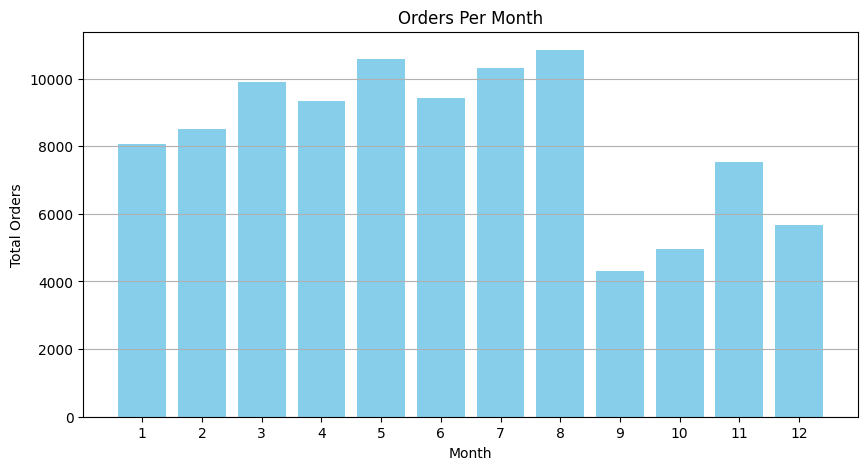

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
from sqlalchemy import create_engine

query = """
SELECT 
    MONTH(order_purchase_timestamp) AS month_no,
    COUNT(order_id) AS total_orders
FROM orders
GROUP BY MONTH(order_purchase_timestamp)
ORDER BY month_no;
"""

df = pd.read_sql_query(query, conn)

plt.figure(figsize=(10,5))
plt.bar(df["month_no"], df["total_orders"], color='skyblue')
plt.xlabel("Month")
plt.ylabel("Total Orders")
plt.title("Orders Per Month")
plt.xticks(range(1,13))
plt.grid(axis='y')
plt.show()


In [13]:
## Query 4:- Top 5 Cities with highest revenue from 2016 to 2018

query = """
SELECT TOP 5
    c.customer_city,
    c.customer_state,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(p.payment_value) AS total_revenue
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN payments p ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
  AND o.order_purchase_timestamp BETWEEN '2016-01-01' AND '2018-12-31'
GROUP BY c.customer_city, c.customer_state
ORDER BY total_revenue DESC;
"""


df = pd.read_sql_query(query, conn)
print(df)


    customer_city customer_state  total_orders  total_revenue
0       sao paulo             SP          9372     1317283.74
1  rio de janeiro             RJ          4042      663167.90
2  belo horizonte             MG          1684      254868.35
3        brasilia             DF          1328      218141.46
4        curitiba             PR           905      140023.37


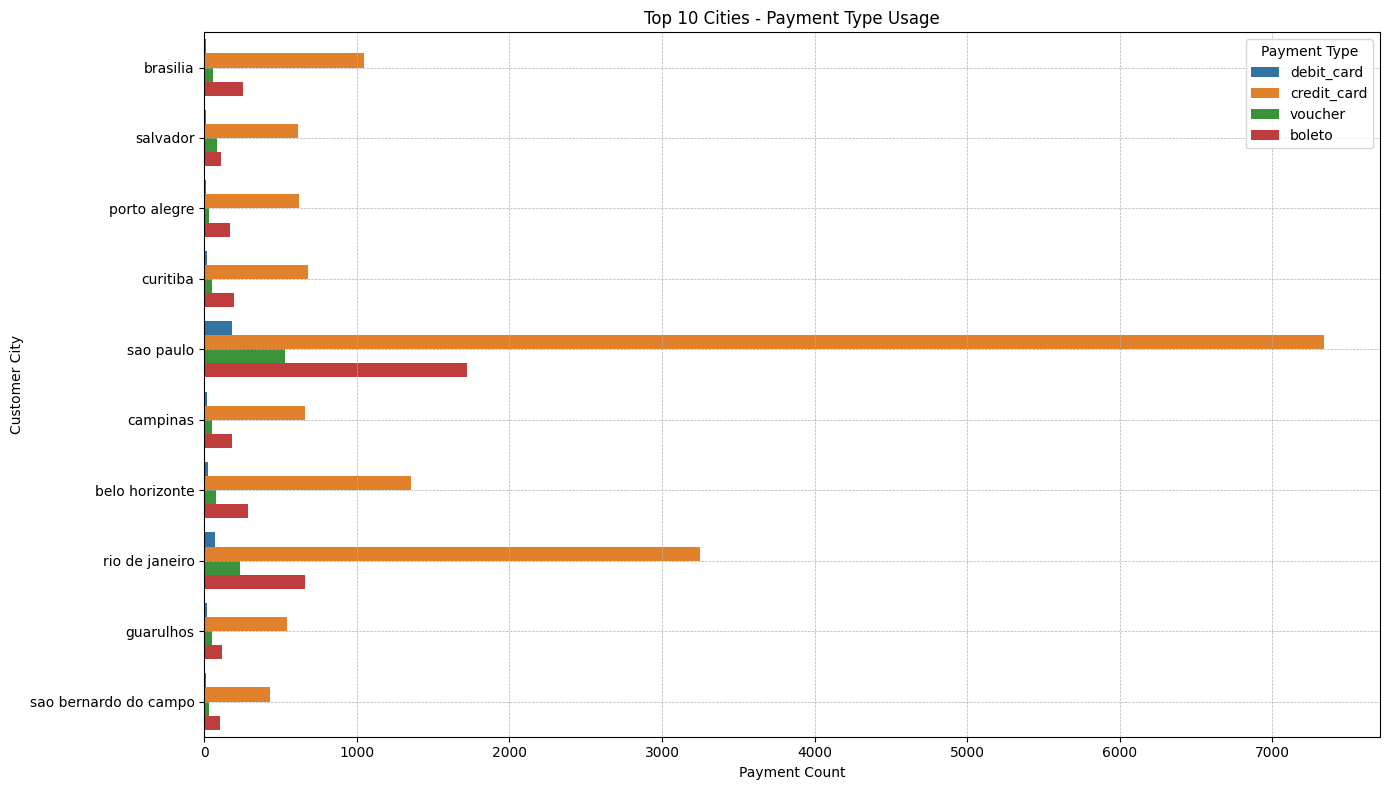

In [16]:
# SQL Query
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc


query = """
SELECT 
    c.customer_city,
    p.payment_type,
    COUNT(*) AS payment_count
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN payments p ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_city, p.payment_type
"""

df = pd.read_sql(query, conn)

# Plotting
plt.figure(figsize=(14, 8))
top_cities = df.groupby("customer_city")["payment_count"].sum().nlargest(10).index
filtered_df = df[df["customer_city"].isin(top_cities)]

sns.barplot(data=filtered_df, x="payment_count", y="customer_city", hue="payment_type")
plt.title("Top 10 Cities - Payment Type Usage")
plt.xlabel("Payment Count")
plt.ylabel("Customer City")
plt.legend(title="Payment Type")
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

                   category  avg_review_score
0         cds_dvds_musicals              4.64
1    books_general_interest              4.45
2   costruction_tools_tools              4.44
3                   flowers              4.42
4            books_imported              4.40
..                      ...               ...
64          fixed_telephony              3.68
65    fashion_male_clothing              3.64
66           home_comfort_2              3.63
67         office_furniture              3.49
68      diapers_and_hygiene              3.26

[69 rows x 2 columns]


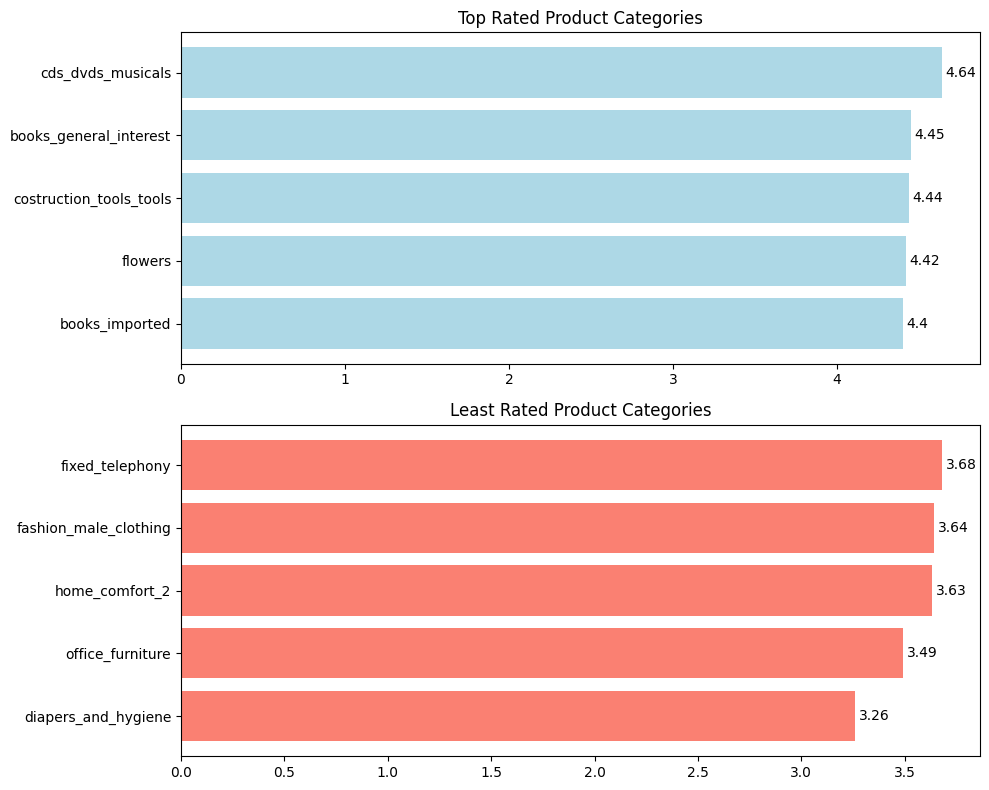

In [18]:

# Query execution (using SQLAlchemy or your existing connection)
query = """
SELECT 
    pct.product_category_name_english AS category,
    ROUND(AVG(r.review_score * 1.0), 2) AS avg_review_score
FROM reviews r
JOIN order_items oi ON r.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN product_category_translation pct ON p.product_category_name = pct.product_category_name
GROUP BY pct.product_category_name_english
HAVING COUNT(r.review_score) > 10
ORDER BY avg_review_score DESC;
"""

df = pd.read_sql(query, conn)
print(df)
# Top 5
top_categories = df.head(5)

# Bottom 5
least_categories = df.tail(5)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Top Rated
ax[0].barh(top_categories['category'], top_categories['avg_review_score'], color='lightblue')
ax[0].set_title("Top Rated Product Categories")
ax[0].invert_yaxis()
for i, v in enumerate(top_categories['avg_review_score']):
    ax[0].text(v + 0.02, i, str(v), va='center')

# Least Rated
ax[1].barh(least_categories['category'], least_categories['avg_review_score'], color='salmon')
ax[1].set_title("Least Rated Product Categories")
ax[1].invert_yaxis()
for i, v in enumerate(least_categories['avg_review_score']):
    ax[1].text(v + 0.02, i, str(v), va='center')

plt.tight_layout()
plt.show()
